In [36]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision.transforms.functional as TF
import wandb
import wandb_util.wandb_util as wbu

# disable gradients
torch.set_grad_enabled(False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


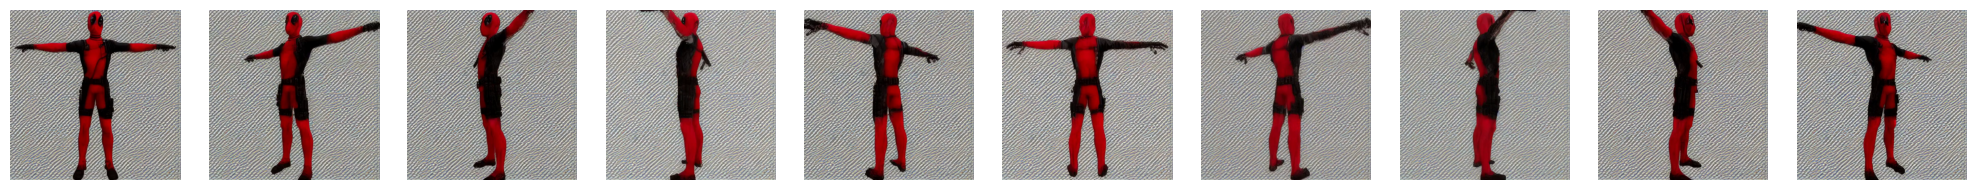

torch.Size([10, 3, 512, 512])

In [37]:
# Read Run
from text3d2video.artifacts.video_artifact import VideoArtifact
from text3d2video.ipython_utils import display_ims

api = wandb.Api()
run = api.run("diffusion-3D-features/jx80zf65")

aggr = wbu.logged_artifacts(run, type="video", name_startswith="aggr")[0]
aggr = VideoArtifact.from_wandb_artifact(aggr)

frames = aggr.get_frames()[0:-1]
feature_maps = [TF.to_tensor(frame) for frame in frames]
feature_maps = torch.stack(feature_maps)

display_ims(frames)
feature_maps.shape

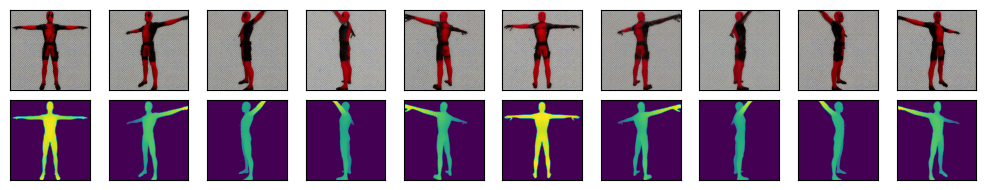

In [38]:
import numpy as np
from pytorch3d.renderer import FoVPerspectiveCameras
from pytorch3d.io import load_objs_as_meshes
from text3d2video.rendering import render_depth_map
from text3d2video.util import read_obj_uvs
from text3d2video.utilities.camera_placement import turntable_extrinsics
from text3d2video.utilities.ipython_utils import display_ims_grid

# TODO replace from reading artifact, here we have prior knowledge
device = "cuda"
angles = np.linspace(0, 360, len(frames), endpoint=False)
R, T = turntable_extrinsics(angles=angles, dists=1.5)
cams = FoVPerspectiveCameras(R=R, T=T, device="cuda", fov=65)
mesh_path = "data/meshes/mixamo-human.obj"
verts_uvs, faces_uvs = read_obj_uvs(mesh_path)
mesh = load_objs_as_meshes([mesh_path], device=device)
meshes = mesh.extend(len(cams))

depths = render_depth_map(meshes, cams)
display_ims_grid([frames, depths], scale=1)

In [39]:
# precompute visible-vert rasterization for each frame
from text3d2video.backprojection import project_visible_texels_to_camera

texture_res = 512
raster_res = 2000

frame_texel_xys = []
frame_texel_uvs = []
for cam, mesh in zip(cams, meshes):
    xys, idxs = project_visible_texels_to_camera(
        mesh, cam, verts_uvs, faces_uvs, texture_res=texture_res, raster_res=raster_res
    )
    frame_texel_xys.append(xys)
    frame_texel_uvs.append(idxs)

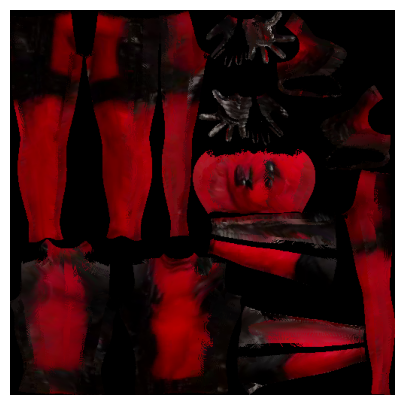

<Figure size 640x480 with 0 Axes>

In [45]:
from text3d2video.backprojection import aggregate_feature_maps_to_uv_texture


texture_aggr = aggregate_feature_maps_to_uv_texture(
    feature_maps.cuda(), texture_res, frame_texel_xys, frame_texel_uvs
)

texture_im = texture_aggr.cpu()
display_ims([texture_im], scale=5)

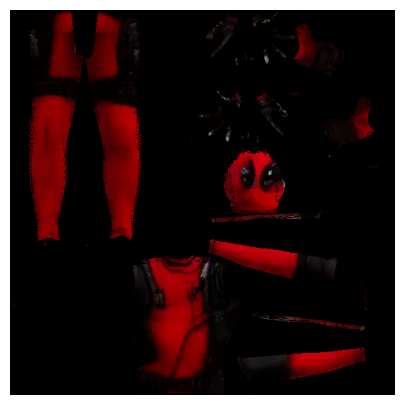

<Figure size 640x480 with 0 Axes>

In [43]:
import torch

from text3d2video.util import sample_feature_map_ndc

idx = 0

texture = torch.zeros(texture_res, texture_res, 3).cpu()

feature_map = feature_maps[idx].cpu()
xys = frame_texel_xys[idx].cpu()
uvs = frame_texel_uvs[idx].cpu()

texel_colors = sample_feature_map_ndc(feature_map, xys)

texture[uvs[:, 1], uvs[:, 0], :] = texel_colors

display_ims([texture], scale=5)

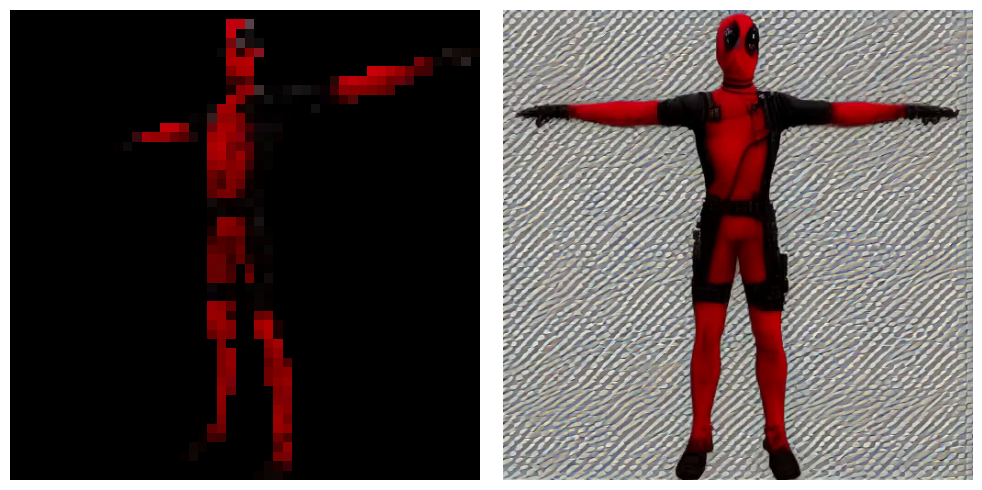

In [17]:
from pytorch3d.renderer import TexturesUV

from pytorch3d.renderer import MeshRasterizer, RasterizationSettings

# precompute rasterization for all views
raster_settings = RasterizationSettings(
    image_size=50, faces_per_pixel=1, blur_radius=0
)
rasterizer = MeshRasterizer(raster_settings=raster_settings)
all_fragments = [rasterizer(meshes[i], cameras=cams[i]) for i in range(len(cams))]



# create mesh with texture
render_cam_i = 1
mesh_copy = mesh.clone()

texture_UV = TexturesUV(
    maps=texture.unsqueeze(0).cuda(),
    verts_uvs=verts_uvs.unsqueeze(0),
    faces_uvs=faces_uvs.unsqueeze(0),
)

render = texture_UV.sample_textures(all_fragments[render_cam_i])[:, :, :, 0, :]

display_ims([render[0].cpu(), frames[0]], scale=5)


tensor(True, device='cuda:0')

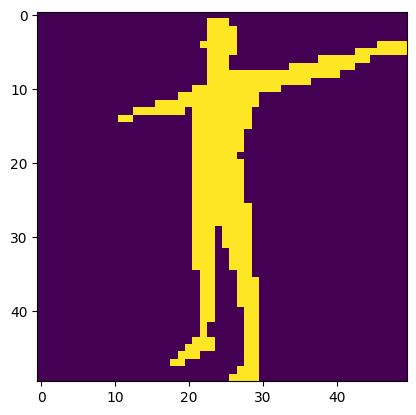

In [35]:
from matplotlib import pyplot as plt

fragments = all_fragments[render_cam_i]
colors = texture_UV.sample_textures(fragments)

valid_max = fragments.pix_to_face >= 0
plt.imshow(valid_max[0, :, :, 0].cpu())

blended = torch.zeros_like(colors)
blended[valid_max] = colors[valid_max]

out_1 = blended[:, :, :, 0, :]
out_2 = colors[:, :, :, 0, :]

(out_1 == out_2).all()